# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
# import missingno as msno
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn import model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Datasets

In [2]:
dic = pd.read_excel("Data Dictionary for QC project.xlsx")
dic['Variable Name'] = dic['Variable Name'].str.strip()

data = pd.read_excel('data.xlsx')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.replace('-0- ',np.nan, inplace=True)
data = data.rename(columns = {'bw44':'bw01','hc44':'hc01'})
data.head()

,codeid,dobyr,bw,ega,nsex,hc,length,apgar1,apgar2,studygr,...,vi,vii,testnumear,IHSABR,Speech Therapy,Physical Therapy,Occupational Therapy,Feeding Therapy,Vision Therapy,Specialized Instriuction
0,509362,1991,3346,40,0,NaN,NaN,9.0,9.0,23,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,959542,1993,3714,40,1,NaN,NaN,NaN,NaN,15,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,510083,1993,3459,40,0,33.000000,48.299999,9.0,9.0,15,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,504281,1998,3600,40,0,NaN,NaN,NaN,NaN,16,...,4.83,NaN,1l,0.0,0,0,0,0,0,0
4,801464,1998,1899,32,1,29.651079,43.000000,NaN,NaN,11,...,5.27,NaN,1l,0.0,0,0,0,0,0,0


In [3]:
data.shape

(3567, 227)

# 3. Data Preparation

## 3.1. Data Dictionary Instructions

In [4]:
at_birth = ["studygr","abnhus","abnplacenta","steroids","apnea","asphyxiahypoxia","autism","autism_sib","phenobrb","csection","seizure","bradycar",
            "breechpres","decels","numdiabetes","discordant","beerwine","csemergency","epi_ethnic","epi_hispanic","immustat","hmd","hyperbil",
            "mgso4","materntemp","meconiumaspiration","metaacid","ivf_natural","nec","nicu","nsex","methadone","pda","nocare","respiredestress",
            "nicotine","barbit","benzodi","cannabis","cocaine","opiate","toxeclam","toxcoml","crack","aborts","i","ii","iii","iv","v","vi","vii",
            "apgar1","apgar2","babynum","bw","discharge_HC","discharge_weight","ega","gravid","hc","newiugr","length","momage","momedu","multinum",
            "dayshosp","dayscpap","daysresp","parity","dobyr"]

red_colored = ['dodisch','tox','amtnico','anemia','daysphoto','ear','testnum','dotabr','intensity','testnumear','dasdot51','dasdot60',"pca00",
               "pca01","pca03","pca04","pca07","pca10","pca13","pca16","pca19","pca22","pca25","pca28","pca34","pca42","pca60","pcanb00",
               "pcanb01",'egaCh','nb']
blue_colored = ['nocare','immustat','barbit','benzodi','cannabis','cocaine','methadone','opiate','nicotine','csection','csemergency',
                   'breechpres','decels','asphyxiahypoxia','bradycar','respiredestress','meconiumaspiration','hyperbil','nec','pda','hmd',
                'seizure','phenobrb','materntemp','daysresp']
purple_notes = ['immustat','csemergency','breechpres','decels','meconiumaspiration']

In [5]:
data.drop(red_colored, axis=1, inplace=True)
data[blue_colored] = data[blue_colored].fillna(0)
data[purple_notes] = np.where(data[purple_notes] == 2, 0, data[purple_notes])

data.shape

(3567, 196)

## 3.2. Droping 25 Month and later longitudinal Tests

In [6]:
# longitudinal data months information
letters = "abcdefghijklmnopqrstuvwxyz_ "
longitude = [int(i) for i in list(set(dic['Variable Name'].str.lower().str.strip(letters))) if i != '']
drop_long = dic[dic['Variable Name'].str.contains('|'.join([str(i) for i in longitude if i > 25 and i != 44]))]['Variable Name'].to_list()
drop_long

['sqreas28',
 'sqcoor28',
 'iqgrff28',
 'sqspee28',
 'sqloco28',
 'sqperf28',
 'sqpers28',
 'sqreas34',
 'sqcoor34',
 'iqgrff34',
 'sqspee34',
 'sqloco34',
 'sqperf34',
 'sqpers34',
 'sqreas42',
 'sqcoor42',
 'iqgrff42',
 'sqspee42',
 'sqloco42',
 'sqperf42',
 'sqpers42',
 'dasdot51',
 'dast51co',
 'dast51ea',
 'dasgca51',
 'dast51na',
 'dasnvb51',
 'dast51pa',
 'dast51pi',
 'dast51ve',
 'dasvrb51',
 'dasdot60',
 'dast60co',
 'dast60ea',
 'dasgca60',
 'dast60na',
 'dasnvb60',
 'dast60pa',
 'dast60pi',
 'dasvrb60',
 'pca28',
 'pca34',
 'pca42',
 'pca60']

In [7]:
drop_long.append('dast60ve')
data.drop([col for col in drop_long if col in data.columns], axis=1, inplace=True)

# new shape
data.shape

(3567, 157)

## 3.3. EI vs. Non-EI Datasets

In [8]:
data['EI Status'] = data[['Speech Therapy','Physical Therapy', 'Occupational Therapy', 'Feeding Therapy',
                          'Specialized Instriuction']].sum(axis=1)

data_nonei = data[data['EI Status'] == 0]
data_ei = data[data['EI Status'] != 0]

In [9]:
df = data_nonei.drop(['Speech Therapy','Physical Therapy', 'Occupational Therapy', 'Feeding Therapy','Vision Therapy','Specialized Instriuction', 
                      'EI Status'], axis=1)
df.shape

(2934, 151)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934 entries, 0 to 3566
Columns: 151 entries, codeid to IHSABR
dtypes: float64(89), int64(13), object(49)
memory usage: 3.4+ MB


## 3.4. Different Datasets

### - longitudinal Tests by months

In [11]:
# df.drop(['gms11.1'],axis=1,inplace=True)

In [12]:
len(at_birth)

71

In [13]:
months = {}
for month in set([int(i) for i in df.columns.str.lower().str.strip(letters) if i != '']):
    months['month_{}'.format(month)] = []
    for i,col in enumerate([int(i) if i != '' else i for i in df.columns.str.lower().str.strip(letters)]):
        if (type(col) == int) and (col < month):
            months['month_{}'.format(month)].append(df.columns[i])
        elif (type(col) == str):
            months['month_{}'.format(month)].append(df.columns[i])

In [14]:
for each in months['month_0']:
    if each not in at_birth:
        months['month_0'].remove(each)
#         print(each)

for each in at_birth:
    if each not in months['month_0']:
        months['month_0'].append(each)
#         print(each)

# 4. Data Pre-Processing

In [15]:
for col in ['i','ii','iii','iv','v','vi']:
    df.loc[df[col] == '.',col] = np.nan
    
categorical_variables = [variable for variable in df.columns if len(df[variable].value_counts()) <= 9]
print('The length of categorical variables:',len(categorical_variables))
df[[col for col in df.columns if col not in categorical_variables]] = df[[col for col in df.columns if col not in categorical_variables]].astype(
    float)
df[[col for col in categorical_variables if col in df.columns]] = df[[col for col in categorical_variables if col in df.columns]].astype(str)

The length of categorical variables: 101


# 5. Imputation of NaNs

In [16]:
df.head()

,codeid,dobyr,bw,ega,nsex,hc,length,apgar1,apgar2,studygr,...,dayscpap,abnhus,i,ii,iii,iv,v,vi,vii,IHSABR
0,509362.0,1991.0,3346.0,40.0,0,NaN,NaN,9.0,9.0,23.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,959542.0,1993.0,3714.0,40.0,1,NaN,NaN,NaN,NaN,15.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
2,510083.0,1993.0,3459.0,40.0,0,33.000000,48.299999,9.0,9.0,15.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,504281.0,1998.0,3600.0,40.0,0,NaN,NaN,NaN,NaN,16.0,...,NaN,0.0,1.59,2.84,4.23,5.57,6.42,4.83,NaN,0.0
4,801464.0,1998.0,1899.0,32.0,1,29.651079,43.000000,NaN,NaN,11.0,...,NaN,0.0,2.19,3.68,5.27,6.57,7.46,5.27,NaN,0.0


In [17]:
df[categorical_variables] = df[categorical_variables].apply(lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]),
                                                                                  index=series[series.notnull()].index))

imputer = KNNImputer(n_neighbors=1)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

,codeid,dobyr,bw,ega,nsex,hc,length,apgar1,apgar2,studygr,...,dayscpap,abnhus,i,ii,iii,iv,v,vi,vii,IHSABR
0,509362.0,1991.0,3346.0,40.0,0.0,33.098881,48.000000,9.0,9.0,23.0,...,2.0,0.0,1.50,2.35,4.35,5.50,6.78,8.15,9.95,1.0
1,959542.0,1993.0,3714.0,40.0,1.0,34.000000,53.299999,8.0,9.0,15.0,...,2.0,0.0,1.59,2.29,4.03,5.03,6.12,4.53,11.93,1.0
2,510083.0,1993.0,3459.0,40.0,0.0,33.000000,48.299999,9.0,9.0,15.0,...,1.0,0.0,1.59,2.74,4.58,5.77,6.82,5.23,10.45,1.0
3,504281.0,1998.0,3600.0,40.0,0.0,31.500000,50.000000,1.0,6.0,16.0,...,3.0,0.0,1.59,2.84,4.23,5.57,6.42,4.83,11.90,0.0
4,801464.0,1998.0,1899.0,32.0,1.0,29.651079,43.000000,9.0,9.0,11.0,...,1.0,0.0,2.19,3.68,5.27,6.57,7.46,5.27,9.07,0.0


# 6. Scaler

In [18]:
## Standard
stdScaler = StandardScaler()
df_std = pd.DataFrame(stdScaler.fit_transform(df), columns = df.columns)
df_std.head()

,codeid,dobyr,bw,ega,nsex,hc,length,apgar1,apgar2,studygr,...,dayscpap,abnhus,i,ii,iii,iv,v,vi,vii,IHSABR
0,0.069236,-1.988567,1.093294,1.274613,-1.061172,0.478766,0.529929,0.844519,0.674746,2.442015,...,-0.385646,-0.458822,-0.763876,-1.313841,-0.647198,-0.709585,-0.462692,0.669440,-0.148757,0.832477
1,1.626506,-1.565274,1.513081,1.274613,0.942354,0.768663,1.590646,0.310391,0.674746,1.024737,...,-0.385646,-0.458822,-0.259061,-1.437530,-1.407525,-1.517332,-1.575526,-1.399185,1.554453,0.832477
2,0.071730,-1.565274,1.222196,1.274613,-1.061172,0.446955,0.589970,0.844519,0.674746,1.024737,...,-0.506350,-0.458822,-0.259061,-0.509862,-0.100712,-0.245561,-0.395248,-0.999175,0.281347,0.832477
3,0.051660,-0.507042,1.383038,1.274613,-1.061172,-0.035605,0.930200,-3.428501,-2.052119,1.201897,...,-0.264941,-0.458822,-0.259061,-0.303713,-0.932320,-0.589283,-1.069693,-1.227752,1.528647,-1.201234
4,1.079680,-0.507042,-0.557336,-0.885199,0.942354,-0.630416,-0.470747,0.844519,0.674746,0.316098,...,-0.506350,-0.458822,3.106376,1.427934,1.538744,1.129327,0.683864,-0.976317,-0.905739,-1.201234


---

In [19]:
df.columns[df.columns.str.contains('25')]

Index(['meii25', 'moii25'], dtype='object')

In [20]:
X, y, y1 = df_std.drop(['codeid','moii25','meii25'],axis=1), df_std['moii25'], df_std['meii25']
X.shape, y.shape, y1.shape

((2934, 148), (2934,), (2934,))

---

## Traditional Statistical Approach

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
print("The Linear Regression results for motor developmental scale 'moii25':\n")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, shuffle=1)
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_test)
print("The Mean Squared Error: ",metrics.mean_squared_error(y_test, y_hat))
print("The R2 Accuracy:\t", metrics.r2_score(y_test,y_hat))

The Linear Regression results for motor developmental scale 'moii25':

The Mean Squared Error:  0.662028530765644
The R2 Accuracy:	 0.27159768902593406


In [23]:
print("The Linear Regression results for mental developmental scale 'meii25':\n")
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.2, random_state = 123, shuffle=1)
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_test)
print("The Mean Squared Error: ",metrics.mean_squared_error(y_test, y_hat))
print("The R2 Accuracy:\t", metrics.r2_score(y_test,y_hat))

The Linear Regression results for mental developmental scale 'meii25':

The Mean Squared Error:  0.49880154527812043
The R2 Accuracy:	 0.5074343115952573


## Machine Learning Approaches

### 1. Random Forest

In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [25]:
# y_hat = cross_val_predict(rf, X, y, cv=10)
# metrics.r2_score(y,y_hat)

In [26]:
print("The Random Forest results for motor developmental scale 'moii25':\n")

cv = KFold(n_splits=10, random_state=1, shuffle=True)
rf = RandomForestRegressor(n_estimators = 100,n_jobs = -1,oob_score = True,bootstrap = True,random_state = 42)
cv_scores_mse = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=cv)
cv_scores_r2 = cross_val_score(rf, X, y, scoring='r2', cv=cv)

print(-cv_scores_mse,'\n')
print(cv_scores_r2,'\n')
print("The Mean Squared Error: ", -np.mean(cv_scores_mse))
print("The R2 Accuracy:\t", np.mean(cv_scores_r2))

The Random Forest results for motor developmental scale 'moii25':

[0.33623248 0.36786907 0.42118609 0.420229   0.40260544 0.2981607
 0.38136482 0.42459795 0.34513903 0.38922498] 

[0.65740125 0.63397546 0.53372085 0.58164582 0.61653574 0.69501216
 0.6432126  0.60134727 0.64982928 0.58606378] 

The Mean Squared Error:  0.37866095763668073
The R2 Accuracy:	 0.6198744213476256


In [27]:
print("The Random Forest results for mental developmental scale 'meii25':\n")
cv = KFold(n_splits=10, random_state=1, shuffle=True)
rf = RandomForestRegressor(n_estimators = 100,n_jobs = -1,oob_score = True,bootstrap = True,random_state = 42)
cv_scores_mse = cross_val_score(rf, X, y1, scoring='neg_mean_squared_error', cv=cv)
cv_scores_r2 = cross_val_score(rf, X, y1, scoring='r2', cv=cv)

print(-cv_scores_mse,'\n')
print(cv_scores_r2,'\n')
print("The Mean Squared Error: ", -np.mean(cv_scores_mse))
print("The R2 Accuracy:\t", np.mean(cv_scores_r2))

The Random Forest results for mental developmental scale 'meii25':

[0.20640263 0.27971706 0.27178413 0.2856561  0.27507476 0.23113447
 0.2685832  0.40782256 0.2317181  0.22016849] 

[0.788057   0.74619447 0.71127771 0.68612612 0.74719232 0.76903196
 0.75284936 0.58751369 0.74265247 0.77008819] 

The Mean Squared Error:  0.26780615015479103
The R2 Accuracy:	 0.7300983289771743


### 2. AdaBoost Regressor

In [30]:
print("The AdABoost Regressor results for motor developmental scale 'moii25':\n")

cv = KFold(n_splits=10, random_state=1, shuffle=True)
ada = AdaBoostRegressor(n_estimators = 100,random_state = 42)
cv_scores_mse = cross_val_score(ada, X, y, scoring='neg_mean_squared_error', cv=cv)
cv_scores_r2 = cross_val_score(ada, X, y, scoring='r2', cv=cv)

print(-cv_scores_mse,'\n')
print(cv_scores_r2,'\n')
print("The Mean Squared Error: ", -np.mean(cv_scores_mse))
print("The R2 Accuracy:\t", np.mean(cv_scores_r2))

The AdABoost Regressor results for motor developmental scale 'moii25':

[0.63689686 0.70618478 0.64526762 0.71433372 0.68193205 0.65374636
 0.76461914 0.71010922 0.66107961 0.68338865] 

[0.35104406 0.2973561  0.28564869 0.28885322 0.35048924 0.33128448
 0.28465749 0.33328227 0.32928268 0.27322416] 

The Mean Squared Error:  0.6857558008545676
The R2 Accuracy:	 0.31251223838676223


In [31]:
print("The AdABoost Regressor results for mental developmental scale 'meii25':\n")

cv = KFold(n_splits=10, random_state=1, shuffle=True)
ada = AdaBoostRegressor(n_estimators = 100,random_state = 42)
cv_scores_mse = cross_val_score(ada, X, y1, scoring='neg_mean_squared_error', cv=cv)
cv_scores_r2 = cross_val_score(ada, X, y1, scoring='r2', cv=cv)

print(-cv_scores_mse,'\n')
print(cv_scores_r2,'\n')
print("The Mean Squared Error: ", -np.mean(cv_scores_mse))
print("The R2 Accuracy:\t", np.mean(cv_scores_r2))

The AdABoost Regressor results for mental developmental scale 'meii25':

[0.48840999 0.57963094 0.5205192  0.51376891 0.56771389 0.57474196
 0.57473203 0.61972114 0.50568031 0.51597401] 

[0.49847986 0.47406304 0.44704094 0.43547979 0.4782421  0.42567189
 0.47113078 0.37319188 0.43838838 0.4611921 ] 

The Mean Squared Error:  0.5460892401332177
The R2 Accuracy:	 0.45028807559117084


### 3. XGBoost Regressor

In [32]:
print("The XGBoost Regressor results for motor developmental scale 'moii25':\n")

cv = KFold(n_splits=10, random_state=1, shuffle=True)
xgb = XGBRegressor(n_estimators = 100,random_state = 42)
cv_scores_mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=cv)
cv_scores_r2 = cross_val_score(xgb, X, y, scoring='r2', cv=cv)

print(-cv_scores_mse,'\n')
print(cv_scores_r2,'\n')
print("The Mean Squared Error: ", -np.mean(cv_scores_mse))
print("The R2 Accuracy:\t", np.mean(cv_scores_r2))

The XGBoost Regressor results for motor developmental scale 'moii25':

[0.36189746 0.37510763 0.44282038 0.47691828 0.41188105 0.33995726
 0.37173332 0.47560898 0.35982357 0.458656  ] 

[0.63125033 0.6267732  0.50977035 0.52520945 0.60770112 0.65225856
 0.6522234  0.55345329 0.63493065 0.51222471] 

The Mean Squared Error:  0.40744039344916844
The R2 Accuracy:	 0.5905795061376737


In [33]:
print("The XGBoost Regressor results for mental developmental scale 'meii25':\n")

cv = KFold(n_splits=10, random_state=1, shuffle=True)
xgb = XGBRegressor(n_estimators = 100,random_state = 42)
cv_scores_mse = cross_val_score(xgb, X, y1, scoring='neg_mean_squared_error', cv=cv)
cv_scores_r2 = cross_val_score(xgb, X, y1, scoring='r2', cv=cv)

print(-cv_scores_mse,'\n')
print(cv_scores_r2,'\n')
print("The Mean Squared Error: ", -np.mean(cv_scores_mse))
print("The R2 Accuracy:\t", np.mean(cv_scores_r2))

The XGBoost Regressor results for mental developmental scale 'meii25':

[0.24887462 0.27678432 0.27225604 0.3351604  0.27997969 0.26785766
 0.29575516 0.43742071 0.25096609 0.22856502] 

[0.74444496 0.74885553 0.71077639 0.63173168 0.74268444 0.73233521
 0.72784569 0.55757705 0.72127554 0.76132007] 

The Mean Squared Error:  0.28936197216874643
The R2 Accuracy:	 0.7078846557485692


---

In [28]:
xx = pd.DataFrame()
xx['Rf_moii25']  = [0.65740125, 0.63397546, 0.53372085, 0.58164582, 0.61653574, 0.69501216, 0.6432126, 0.60134727, 0.64982928, 0.58606378] 
# xx['ABR_moii25'] = [0.36208929, 0.28661554, 0.29513724, 0.29773388, 0.30924853, 0.3585053, 0.28666688, 0.33631373, 0.33050797, 0.25978952]
xx['XGB_moii25'] = [0.63125033, 0.6267732,  0.50977035, 0.52520945, 0.60770112, 0.65225856, 0.6522234,  0.55345329, 0.63493065, 0.51222471]
xx['LSR_moii25'] = [0.271592, 0.271592, 0.271592, 0.271592, 0.271592, 0.271592, 0.271592, 0.271592, 0.271592, 0.271592]

xx['Rf_meii25']  = [0.788057, 0.74619447, 0.71127771, 0.68612612, 0.74719232, 0.76903196, 0.75284936, 0.58751369, 0.74265247, 0.77008819]
# xx['ABR_meii25'] = [0.49847986, 0.47406304, 0.44704094, 0.43547979, 0.4782421,  0.42567189, 0.47113078, 0.37319188, 0.43838838, 0.4611921 ]
xx['XGB_meii25'] = [0.74444496, 0.74885553, 0.71077639, 0.63173168, 0.74268444, 0.73233521, 0.72784569, 0.55757705, 0.72127554, 0.76132007]
xx['LSR_meii25'] = [0.507434, 0.507434, 0.507434, 0.507434, 0.507434, 0.507434, 0.507434, 0.507434, 0.507434, 0.507434]
xx

,Rf_moii25,XGB_moii25,LSR_moii25,Rf_meii25,XGB_meii25,LSR_meii25
0,0.657401,0.631250,0.271592,0.788057,0.744445,0.507434
1,0.633975,0.626773,0.271592,0.746194,0.748856,0.507434
2,0.533721,0.509770,0.271592,0.711278,0.710776,0.507434
3,0.581646,0.525209,0.271592,0.686126,0.631732,0.507434
4,0.616536,0.607701,0.271592,0.747192,0.742684,0.507434
5,0.695012,0.652259,0.271592,0.769032,0.732335,0.507434
6,0.643213,0.652223,0.271592,0.752849,0.727846,0.507434
7,0.601347,0.553453,0.271592,0.587514,0.557577,0.507434
8,0.649829,0.634931,0.271592,0.742652,0.721276,0.507434
9,0.586064,0.512225,0.271592,0.770088,0.761320,0.507434


In [29]:
xx.mean()

Rf_moii25     0.619874
XGB_moii25    0.590580
LSR_moii25    0.271592
Rf_meii25     0.730098
XGB_meii25    0.707885
LSR_meii25    0.507434
dtype: float64

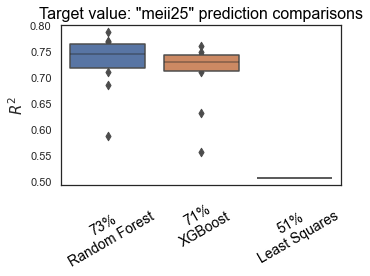

In [36]:
sns.set_style("white")
# plt.scatter(x = ['Rf_meii25', 'XGB_meii25', 'LSR_meii25'], y = [ 0.26834, 0.29343, 0.49846], c='#8B0000', label='MSE',
#             marker='x')
# plt.legend(loc='best')
bb = sns.boxenplot(data =xx[['Rf_meii25', 'XGB_meii25', 'LSR_meii25']])
plt.title('Target value: "meii25" prediction comparisons',fontsize=16,color='black')
bb.set_xticklabels(rotation=30,labels=['73%\nRandom Forest','71%\nXGBoost','51%\nLeast Squares'],fontsize=14,color='black')
# bb.text(1,0.6, "%45", horizontalalignment='center', size='medium', color='black')
# sns.set(rc={'figure.figsize':(5,4)})
plt.ylabel('$R^2$',fontsize=15)
plt.tight_layout()
plt.savefig('meii25-allFeature-comparison.png')

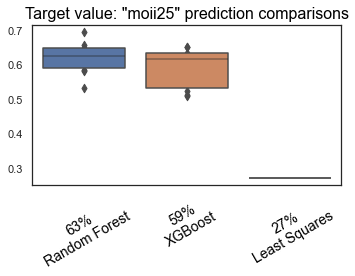

In [37]:
sns.set_style("white")
# plt.scatter(x = ['Rf_moii25', 'XGB_moii25','LSR_moii25'], y = [ 0.37757, 0.403049, 0.657491], c='#8B0000', label='MSE',
#             marker='x')
# plt.legend(loc='lower left')
aa = sns.boxenplot(data =xx[['Rf_moii25', 'XGB_moii25', 'LSR_moii25']])
plt.title('Target value: "moii25" prediction comparisons',fontsize=16,color='black')
aa.set_xticklabels(rotation=30,labels=['63%\nRandom Forest','59%\nXGBoost','27%\nLeast Squares'],fontsize=14,color='black')
# sns.set(rc={'figure.figsize':(5,4)})
plt.tight_layout()
plt.savefig('moii25-allFeature-comparison.png')

# 8. Feature Selection

In [28]:
def feature_importance(X,y,method):
    if method == "lr":
        model = LinearRegression()
        model.fit(X,y)
        features = X.columns
        importances = model.coef_
        model = pd.DataFrame([features,importances]).T
        model.columns = ['Variable', 'Importance']
        model.sort_values(by='Importance',inplace=True, ascending=False)
        model.reset_index(drop=True, inplace=True)
        return model
    elif method == "rf":
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif method == "abr":
        model = AdaBoostRegressor(random_state=42,learning_rate=1)
    elif method == "xgb":
        model = XGBRegressor(random_state=42,learning_rate=1)
    model.fit(X,y)
    features = X.columns
    importances = model.feature_importances_
    model = pd.DataFrame([features,importances]).T
    model.columns = ['Variable', 'Importance']
    model.sort_values(by='Importance',inplace=True, ascending=False)
    model.reset_index(drop=True, inplace=True)
    return model

In [29]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
mdl = XGBRegressor(n_estimators = 100,random_state = 42)
np.mean(cross_val_score(mdl, X[feature_importance(X,y1,'xgb')['Variable'][:10]], y1, scoring='r2', cv=cv))

0.82130822240395

In [30]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
mdl = AdaBoostRegressor(n_estimators = 100,random_state = 42)
np.mean(cross_val_score(mdl, X, y, scoring='r2', cv=cv))

0.31251223838676223

In [154]:
print('moii25 target value\n')
xx = pd.DataFrame({'All Features':[0.6188, 0.3125, 0.5906],
             'Top 30 Features': [0.6656, 0.3186, 0.7013], 
              'Top 20 Features': [0.7136, 0.31, 0.7211], 
              'Top 10 Features': [0.7441, 0.3214, 0.7391],
             '$R^2$ Results': ['Random Forest', 'AdaBoost','XGBoost']}).set_index('$R^2$ Results')
xx

moii25 target value



,All Features,Top 30 Features,Top 20 Features,Top 10 Features
$R^2$ Results,,,,
Random Forest,0.6188,0.6656,0.7136,0.7441
AdaBoost,0.3125,0.3186,0.3100,0.3214
XGBoost,0.5906,0.7013,0.7211,0.7391


In [155]:
xx.T

$R^2$ Results,Random Forest,AdaBoost,XGBoost
All Features,0.6188,0.3125,0.5906
Top 30 Features,0.6656,0.3186,0.7013
Top 20 Features,0.7136,0.3100,0.7211
Top 10 Features,0.7441,0.3214,0.7391


In [156]:
print('meii25 target value\n')
xx = pd.DataFrame({'All Features':[0.7301, 0.4503, 0.7079],
             'Top 30 Features': [0.7610, 0.4461, 0.7746], 
              'Top 20 Features': [0.7851, 0.4562, 0.7981], 
              'Top 10 Features': [0.8113, 0.4431, 0.8313],
             '$R^2$ Results': ['Random Forest', 'AdaBoost','XGBoost']}).set_index('$R^2$ Results')
xx

meii25 target value



,All Features,Top 30 Features,Top 20 Features,Top 10 Features
$R^2$ Results,,,,
Random Forest,0.7301,0.7610,0.7851,0.8113
AdaBoost,0.4503,0.4461,0.4562,0.4431
XGBoost,0.7079,0.7746,0.7981,0.8313


In [157]:
xx.T

$R^2$ Results,Random Forest,AdaBoost,XGBoost
All Features,0.7301,0.4503,0.7079
Top 30 Features,0.7610,0.4461,0.7746
Top 20 Features,0.7851,0.4562,0.7981
Top 10 Features,0.8113,0.4431,0.8313


# 9. Longitudinal Comparison

## 9.1. Fixed Target Value, Different Predictors

In [31]:
def get_scores(month,X,y, method):
    
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    if method == "rf":
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif method == "abr":
        model = AdaBoostRegressor(random_state=42,learning_rate=1)
    elif method == "xgb":
        model = XGBRegressor(random_state=42,learning_rate=1)
     
    X_feat = X[[col for col in months[month] if col in X.columns]]
    model.fit(X_feat, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # top 10 features
    features = [X_feat.columns[i] for i in indices]
        
    cv_scores_r2 = cross_val_score(model, X_feat[features], y, scoring='r2', cv=cv)
        
    return features, np.mean(cv_scores_r2)

In [32]:
months.keys()

dict_keys(['month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_7', 'month_10', 'month_13', 'month_16', 'month_19', 'month_22', 'month_25'])

In [33]:
month_feat = {}
month_score = {}
for month in [m for m in months.keys()]:
# for month in [m for m in months.keys() if m not in ['month_25', 'month_60']]:
    month_feat['{}'.format(month)] = get_scores(month,X,y1,'rf')[0]
    month_score['{}'.format(month)] = get_scores(month,X,y1,'rf')[1]

In [34]:
month_feat2 = {}
month_score2 = {}
for month in [m for m in months.keys()]:
# for month in [m for m in months.keys() if m not in ['month_25', 'month_60']]:
    month_feat2['{}'.format(month)] = get_scores(month,X,y,'rf')[0]
    month_score2['{}'.format(month)] = get_scores(month,X,y,'rf')[1]

In [35]:
yy = pd.DataFrame()
yy['time'] = month_score.keys()
yy['moii25'] = month_score2.values()
yy['meii25'] = month_score.values()

yy = pd.melt(yy, id_vars="time", var_name="Target Value", value_name="R2")

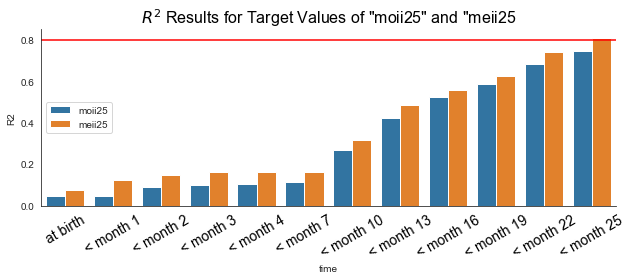

In [36]:
sns.set_style("white")
aa = sns.factorplot(x='time', y='R2', hue='Target Value', data=yy, kind='bar',size=4, aspect=2)
aa.set_xticklabels(rotation=30,labels=['at birth','< month 1','< month 2','< month 3','< month 4','< month 7','< month 10',
                                        '< month 13','< month 16','< month 19','< month 22','< month 25'],fontsize=14,color='black')
aa._legend.remove()
plt.axhline(y=0.8, color='r', linestyle='-')
plt.legend(loc='best')
plt.title('$R^2$ Results for Target Values of "moii25" and "meii25',fontsize=16,color='black')
plt.tight_layout()
# plt.savefig('preictores-comparison.png')
plt.show()

In [66]:
# dic[dic['Variable Name'].isin(months['month_0'])][['Variable Name','Description']].to_excel('At-birth Variables.xlsx')

## 8.1. At-birth as predictor and Longitudinal months as output

In [37]:
dic[dic['Variable Name'].str.contains('meii')]['Variable Name'].values

array(['meii10', 'meii13', 'meii16', 'meii19', 'meii22', 'meii25',
       'meii04', 'meii07'], dtype=object)

In [38]:
X_ab = X[at_birth]
X_ab.shape

(2934, 71)

In [39]:
def get_scores_ab(xx,yy1):
    yyy = df_std[yy1]
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
#     rf = XGBRegressor(n_estimators=100, n_jobs=-1)
    rf.fit(xx, yyy)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-10:]  # top 30 features
    features = [xx.columns[i] for i in indices]
    cv_scores_r2 = cross_val_score(rf, xx[features], yyy, scoring='r2', cv=10)
#     score = rf_regress(xx[features], yyy)
#     importances[indices].sum()
    return features, np.mean(cv_scores_r2)

In [40]:
X, y, y1 = df_std.drop(['codeid','moii25','meii25'],axis=1), df_std['moii25'], df_std['meii25']

In [41]:
X.shape

(2934, 148)

In [48]:
birth_feat = {}
birth_score = {}
for yy1 in ['meii04', 'meii07', 'meii10', 'meii13', 'meii16', 'meii19','meii22', 'meii25']:
    birth_feat['{}'.format(yy1)] = get_scores_ab(X_ab,yy1)[0]
    birth_score['{}'.format(yy1)] = get_scores_ab(X_ab,yy1)[1]

In [49]:
birth_feat2 = {}
birth_score2 = {}
for yy2 in ['moii04', 'moii07', 'moii10', 'moii13', 'moii16', 'moii19','moii22', 'moii25']:
    birth_feat2['{}'.format(yy)] = get_scores_ab(X_ab,yy2)[0]
    birth_score2['{}'.format(yy)] = get_scores_ab(X_ab,yy2)[1]

In [1]:
zz = pd.DataFrame()
zz['time'] = birth_score.keys()
zz['motor develop.'] = birth_score2.values()
zz['mental develop.'] = birth_score.values()

zz = pd.melt(zz, id_vars="time", var_name="Target Value", value_name="R2")

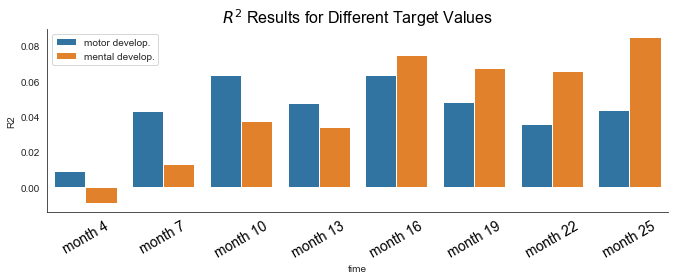

In [46]:
sns.set_style("white")
aa = sns.factorplot(x='time', y='R2', hue='Target Value', data=zz, kind='bar',size=4, aspect=2)
aa.set_xticklabels(rotation=30,labels=['month 4','month 7','month 10','month 13','month 16','month 19','month 22',
                                        'month 25'],fontsize=14,color='black')
aa._legend.remove()
# plt.axhline(y=0.8, color='r', linestyle='-')
plt.legend(loc='best')
plt.title('$R^2$ Results for Different Target Values', fontsize=16,color='black')
plt.tight_layout()
# plt.savefig('at-birth-results.png')
plt.show()

---